In [2]:
import ipywidgets as widgets
import qgrid

from scipy.stats import nbinom
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown
import pandas as pd
import csv
import numpy as np
import datetime
import re
import warnings
from IPython.display import HTML, display
import requests
import sys
from scipy.optimize import curve_fit

from scipy.stats import lognorm


from ipywidgets import Layout, Button, VBox, HBox, Box, FloatText, Textarea, Dropdown, Label, IntSlider, FloatSlider

warnings.filterwarnings('ignore')
plt.ioff()

%config InlineBackend.figure_format = 'svg'

df, obs_pred_r2_G, model_G, loc, obs_x_G, obs_y_G, pred_y_G, forecasted_x_G, forecasted_y_G = [], [], [], [], [], [], [], [], []
dates, fdates, new_cases, table_vals = [], [], [], []

In [3]:

def logistic(x, a, b, c, d):
    return a / (d + np.exp(-c * x + b))

def exponential(x, a, b, c, d):
    return a * (d + (np.exp(b * x) + c))

def obs_pred_rsquare(obs, pred):
    return 1 - sum((obs - pred) ** 2) / sum((obs - np.mean(obs)) ** 2)


def get_logistic(obs_x, obs_y):

    obs_x = np.array(obs_x)
    for i, val in enumerate(obs_y):
        if val == 0:
            try:
                obs_y[i] = obs_y[i-1]
            except:
                pass       
    
    obs_y = np.array(obs_y)
    
    try:
        popt, pcov = curve_fit(logistic, obs_x, obs_y)
        pred_y = logistic(obs_x, *popt)
        forecasted_x = np.array(list(range(max(obs_x) + 16)))
        forecasted_y = logistic(forecasted_x, *popt)
        
    except:
        print('Logistic failed to fit. Using 3rd degree polynomial.')
        forecasted_y, forecasted_x, pred_y = get_polynomial(obs_x, obs_y)
        
    return forecasted_y, forecasted_x, pred_y



def get_exponential(obs_x, obs_y):
    
    obs_x = np.array(obs_x)
    
    for i, val in enumerate(obs_y):
        if val == 0:
            try:
                obs_y[i] = obs_y[i-1]
            except:
                pass       
    
    obs_y = np.array(obs_y)
    
    try:
        popt, pcov = curve_fit(exponential, obs_x, obs_y)
        pred_y = exponential(obs_x, *popt)
        forecasted_x = np.array(list(range(max(obs_x) + 16)))
        forecasted_y = exponential(forecasted_x, *popt)
        
    except:
        print('Exponential failed to fit. Using 3rd degree polynomial.')
        forecasted_y, forecasted_x, pred_y = get_polynomial(obs_x, obs_y)
        
    return forecasted_y, forecasted_x, pred_y
        


def get_polynomial(obs_x, obs_y):
    
    obs_x = np.array(obs_x)
    for i, val in enumerate(obs_y):
        if val == 0:
            try:
                obs_y[i] = obs_y[i-1]
            except:
                pass       
    
    obs_y = np.array(obs_y)
    
    try:
        z = np.polyfit(obs_x, obs_y, 2)
        p = np.poly1d(z)
        pred_y = p(obs_x)
            
        forecasted_x = np.array(list(range(max(obs_x) + 16)))
        forecasted_y = p(forecasted_x)
    except:
        pass
    
    return forecasted_y, forecasted_x, pred_y



def get_best(obs_x, obs_y, model, df_sub):
    
    obs_x = np.array(obs_x)
    for i, val in enumerate(obs_y):
        if val == 0:
            try:
                obs_y[i] = obs_y[i-1]
            except:
                pass     
            
    obs_y = np.array(obs_y)
    
    best_r2 = 0
    best_model = str()
    best_loc = str()
    best_pred_y = []
    best_forecasted_x = []
    best_forecasted_y = []
    
    bench_x, bench_y = [], []
    
    locs = list(set(df_sub['Province/State']))
    for loc in locs:
        df_benchmark = df_sub[df_sub['Province/State'] == loc]
        bench = df_benchmark.iloc[0,6:].values
        
        bench_y = []
        for i, val in enumerate(bench):
            if len(bench_y) > 0 or val > 0:
                bench_y.append(val)

        bench_x = list(range(len(bench_y)))
        if len(bench_x) <= len(obs_x) or sum(bench_y) <= sum(obs_y): 
            continue
        
        z = np.polyfit(bench_x, bench_y, 2)
        p = np.poly1d(z)
        pred_y = p(obs_x)
            
        forecasted_x = np.array(list(range(len(obs_x) + 16)))
        forecasted_y = p(forecasted_x)
        
        obs_pred_r2 = obs_pred_rsquare(obs_y, pred_y)
        
        if obs_pred_r2 > best_r2:
            best_r2 = float(obs_pred_r2)
            best_loc = loc
            best_pred_y = pred_y
            best_forecasted_x = forecasted_x
            best_forecasted_y = forecasted_y
            
    if len(best_forecasted_x) == 0:
        print('Failed to find a Best Benchmark failed. Using 3rd degree polynomial.')
        best_forecasted_y, best_forecasted_x, best_pred_y = get_polynomial(obs_x, obs_y)
        best_loc = 'None'
        best_r2 = 0

    return best_r2, best_loc, best_pred_y, best_forecasted_x, best_forecasted_y



def fit_curve(obs_x, obs_y, model, df_sub):

    obs_x = list(range(len(obs_y)))
    obs_x = np.array(obs_x)
    obs_y = np.array(obs_y)
    
    best_loc = str()
    
    if model == 'Best Benchmark':
        obs_pred_r2, best_loc, pred_y, forecasted_x, forecasted_y = get_best(obs_x, obs_y, model, df_sub)
        if obs_pred_r2 == 0 and best_loc == 'None':
            obs_pred_r2 = obs_pred_rsquare(obs_y, pred_y)
            
    elif model == 'logistic':
        forecasted_y, forecasted_x, pred_y = get_logistic(obs_x, obs_y)
        obs_pred_r2 = obs_pred_rsquare(obs_y, pred_y)
    elif model == 'exponential':
        forecasted_y, forecasted_x, pred_y = get_exponential(obs_x, obs_y)
        obs_pred_r2 = obs_pred_rsquare(obs_y, pred_y)
    elif model == 'polynomial':
        forecasted_y, forecasted_x, pred_y = get_polynomial(obs_x, obs_y)
        obs_pred_r2 = obs_pred_rsquare(obs_y, pred_y)
        
    return obs_pred_r2, model, best_loc, obs_x, pred_y, forecasted_x, forecasted_y


In [283]:
class App_GetFits:
    
    def __init__(self, df):
        
        # model: 'logistic'; 'exponential'; 'polynomial';
        # query: Any location available within the dataframe
        # refer: Any location available within the dataframe
        
        self._df = df
        available_indicators2 = list(set(self._df['Province/State']))
        available_indicators2.sort()
        
        self._1_dropdown = self._create_dropdown(['logistic', 'exponential', 'polynomial', 'Best Benchmark'], 2, label = 'Choose a model to fit:')
        self._2_dropdown = self._create_dropdown(available_indicators2, 16, label = 'Choose your location:')
        self._3_floattext = self._create_floattext(label = '% Visiting your hospital:', val=10)
        self._4_floattext = self._create_floattext(label = '% Admitted to your hospital:', val=50)
        self._5_floattext = self._create_floattext(label = '% Admitted to critical care:', val=20)
        self._plot_container = widgets.Output()
        
        _app_container = widgets.VBox(
            [widgets.VBox([widgets.HBox([self._1_dropdown, self._2_dropdown], 
                             layout=widgets.Layout(align_items='flex-start', flex='0 auto auto', width='66.5%')),
                           widgets.HBox([self._3_floattext, self._4_floattext, self._5_floattext],
                             layout=widgets.Layout(align_items='flex-start', flex='0 0 auto', width='100%'))],
                         layout=widgets.Layout(
            display='flex', flex_flow='column', border='solid 2px', align_items='stretch', width='100%')),
                           self._plot_container], 
            layout=widgets.Layout(
            display='flex', flex_flow='column', border='solid 4px', align_items='stretch', width='100%'))
                
        # 'flex-start', 'flex-end', 'center', 'baseline', 'stretch', 'inherit', 'initial', 'unset'
        self.container = widgets.VBox([
            widgets.HBox([
                _app_container
            ])
        ], layout=widgets.Layout(flex='1 1 auto', margin='0 auto 0 auto', max_width='1024px'))
        self._update_app()
        
        
    @classmethod
    def from_url(cls):
        
        _URL = 'https://raw.githubusercontent.com/klocey/ResourceDemand/master/notebooks/COVID-CASES-DF.txt'
        df = pd.read_csv(_URL, sep='\t')  
        df = df[df['Country/Region'] == 'US']
        
        patternDel = ","
        filter = df['Province/State'].str.contains(patternDel)
        df = df[~filter]
        df = df.drop(df.columns[0], axis=1)
        
        df['sum'] = df.iloc[:, 6:].sum(axis=1)
        df = df[df['sum'] > 1]
        df = df.drop(['sum'], axis=1)
        
        return cls(df)
        
        
    def _create_dropdown(self, indicators, initial_index, label):
        dropdown = widgets.Dropdown(options=indicators, 
                                    layout={'width': '50%'},
                                    style={'description_width': '50%'},
                                    value=indicators[initial_index],
                                   description=label,
                                   )
        
        dropdown.observe(self._on_change, names=['value'])
        return dropdown
    
    def _create_floattext(self, label, val):
        obj = widgets.BoundedFloatText(
                    value=val,
                    description=label,
                    disabled=False,
                    layout={'width': '33%'},
                    style={'description_width': '50%'},
                )
        obj.observe(self._on_change, names=['value'])
        return obj
    
    
    def _get_fit(self, model, loc, per_loc, per_admit, per_cc):
        
        per_loc = per_loc * 0.01
        per_admit = per_admit * 0.01
        per_cc = per_cc * 0.01
        
        global obs_pred_r2_G
        global model_G
        global loc_G
        global obs_x_G
        global obs_y_G
        global pred_y_G
        global forecasted_x_G
        global forecasted_y_G
        global dates
        global fdates
        global new_cases
        
        df_sub = self._df[self._df['type'] == 'Confirmed']
        df_sub = df_sub[df_sub['Province/State'] == loc]
        df_sub = df_sub.loc[:, (df_sub != 0).any(axis=0)]
        yi = list(df_sub)
        DATES = yi[6:]
        focal = df_sub.iloc[0,6:].values
        
        y = []
        dates = []
        for i, val in enumerate(focal):
            if len(y) > 0 or val > 0:
                y.append(val)
                dates.append(DATES[i])

        x = list(range(len(y)))
        
        obs_pred_r2_G, model_G, loc_G, obs_x_G, pred_y_G, forecasted_x_G, forecasted_y_G = fit_curve(x, y, model, df_sub)
        obs_y_G = np.array(list(y))

        if obs_pred_r2_G < 0:
            obs_pred_r2_G = 0.0

            
            
            
        fig = plt.figure(figsize=(12, 10))

        ax = plt.subplot2grid((4, 4), (0, 0), colspan=2, rowspan=2)
        #ax = plt.gca()

        y = np.array(y)
        y[y < 0] = 0
        pred_y_G = np.array(pred_y_G)
        pred_y_G[pred_y_G < 0] = 0

        forecasted_y_G = np.array(forecasted_y_G)
        forecasted_y_G[forecasted_y_G < 0] = 0
        forecast_vals = np.copy(forecasted_y_G)

        numdays = len(forecasted_x_G)
        latest_date = pd.to_datetime(dates[-1])
        first_date = pd.to_datetime(dates[0])

        future_date = latest_date + datetime.timedelta(days = 15)
        fdates = pd.date_range(start=first_date, end=future_date)
        fdates = fdates.strftime('%m/%d')

        #print(len(fdates), len(forecasted_y_G))
        #sys.exit()
        
        plt.plot(fdates, forecasted_y_G, c='Crimson', linewidth=3, label='Forecasted')

        latest_date = pd.to_datetime(dates[-1])
        first_date = pd.to_datetime(dates[0])
        dates = pd.date_range(start=first_date, end=latest_date)
        dates = dates.strftime('%m/%d')

        lab1 = r'$r^{2}$' + ' = ' + str(np.round(obs_pred_r2_G, 2))
        plt.scatter(dates, y, c='0.2', s=100, alpha=0.3, linewidths=0.1)
        plt.plot(dates, pred_y_G, c='steelblue', linewidth=3, label='Predicted ' + lab1)

        forecast_vals = forecast_vals.tolist()

        new_cases = []
        for i, val in enumerate(forecast_vals):
            if i > 0:
                new_cases.append(forecast_vals[i] - forecast_vals[i-1])
            if i == 0:
                new_cases.append(forecast_vals[i])


        leg = ax.legend(handlelength=0, handletextpad=0, fancybox=False,
                        loc='best', frameon=False, fontsize=14)

        for line,text in zip(leg.get_lines(), leg.get_texts()):
            text.set_color(line.get_color())

        for item in leg.legendHandles: 
            item.set_visible(False)

        plt.xticks(rotation=35, ha='center')
        plt.xlabel('Date', fontsize=14, fontweight='bold')
        plt.ylabel('Confirmed cases', fontsize=14, fontweight='bold')

        if len(forecasted_x_G) < 10:
            i = 1
        elif len(forecasted_x_G) < 20:
            i = 4
        elif len(forecasted_x_G) < 40:
            i = 6
        else:
            i = 8

        for label in ax.xaxis.get_ticklabels()[::i]:
            label.set_visible(False)

        ax = plt.gca()
        temp = ax.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::i]))
        for label in temp:
            label.set_visible(False)
            
        plt.title('Model fitting', fontsize = 16, fontweight = 'bold')

        
        ax = plt.subplot2grid((4, 4), (0, 2), colspan=2, rowspan=2)
        ax.axis('off')
        #ax.axis('tight')

        if len(loc) > 12:
            loc = loc[:12]
            loc = loc + '...'

        col_labels = ['Cumulative', 'New', 'Your hospital', 'Admitted']

        row_labels = fdates.tolist()
        row_labels = row_labels[-15:]

        new_cases = np.round(new_cases, 1)#.astype('int')
        new_cases = new_cases[-15:]

        sub_f = forecasted_y_G[-15:]

        table_vals = []
        clr_vals = []
        for i in range(len(row_labels)):

            val = new_cases[i]
            cell = [int(np.round(sub_f[i])), 
                    int(np.round(val)), 
                    int(np.round(val * per_loc)),
                    int(np.round(per_admit * val * per_loc))]
            
            clr = ['0.4', '0.5', '0.6', '0.7']
            table_vals.append(cell)
            clr_vals.append(clr)

        ncol = 4
        the_table = plt.table(cellText=table_vals,
                        colWidths=[0.22] * ncol,
                        rowLabels=row_labels,
                        colLabels=col_labels,
                        cellLoc='center',
                        loc='lower center')#,
                        #cellColours=clr_vals)
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(10)
        the_table.scale(1, 1.32)
        plt.title('Forecasted cases for '+ loc, fontsize = 16, fontweight = 'bold')
        
        
        
        
        ax = plt.subplot2grid((4, 4), (2, 0), colspan=2, rowspan=2)
        pi_dates = fdates[7:]
        
        N = []
        days_in_nc = [[0]*len(pi_dates) for i in range(len(pi_dates))]
        days_in_cc = [[0]*len(pi_dates) for i in range(len(pi_dates))]
        
        #### Construct arrays for critical care and non-critical care patients
        cc = per_cc * per_admit * per_loc * np.array(new_cases)
        cc = cc.tolist()
        nc = (1 - per_cc) * per_admit * per_loc * np.array(new_cases)
        nc = nc.tolist()
        
        n_cc, p_cc = 20, 0.5
        n_nc, p_nc = 10, 0.5
        
        rv_cc = binom(n_cc, p_cc)
        rv_nc = binom(n_nc, p_nc)
        
        for i, day in enumerate(pi_dates):
            # 20% admitted are critical care
            # LOS for non critical care = 5 days
            # LOS for critical care = 10 days

            days_in_nc[0][i] = cc[i]
            days_in_cc[0][i] = nc[i]
            
            if i > 0:
                j = 1
                days_in_nc[j][i] = days_in_nc[j-1][i-1] * (1 - rv_nc.pmf(j))
                days_in_cc[j][i] = days_in_cc[j-1][i-1] * (1 - rv_cc.pmf(j))
            if i > 1:
                j = 2
                days_in_nc[j][i] = days_in_nc[j-1][i-1] * (1 - rv_nc.pmf(j))
                days_in_cc[j][i] = days_in_cc[j-1][i-1] * (1 - rv_cc.pmf(j))
            if i > 2:
                j = 3
                days_in_nc[j][i] = days_in_nc[j-1][i-1] * (1 - rv_nc.pmf(j))
                days_in_cc[j][i] = days_in_cc[j-1][i-1] * (1 - rv_cc.pmf(j))
            if i > 3:
                j = 4
                days_in_nc[j][i] = days_in_nc[j-1][i-1] * (1 - rv_nc.pmf(j))
                days_in_cc[j][i] = days_in_cc[j-1][i-1] * (1 - rv_cc.pmf(j))
            if i > 4:
                j = 5
                days_in_nc[j][i] = days_in_nc[j-1][i-1] * (1 - rv_nc.pmf(j))
                days_in_cc[j][i] = days_in_cc[j-1][i-1] * (1 - rv_cc.pmf(j))
            if i > 5:
                j = 6
                days_in_nc[j][i] = days_in_nc[j-1][i-1] * (1 - rv_nc.pmf(j))
                days_in_cc[j][i] = days_in_cc[j-1][i-1] * (1 - rv_cc.pmf(j))
            if i > 6:
                j = 7
                days_in_nc[j][i] = days_in_nc[j-1][i-1] * (1 - rv_nc.pmf(j))
                days_in_cc[j][i] = days_in_cc[j-1][i-1] * (1 - rv_cc.pmf(j))
            if i > 7:
                j = 8
                days_in_nc[j][i] = days_in_nc[j-1][i-1] * (1 - rv_nc.pmf(j))
                days_in_cc[j][i] = days_in_cc[j-1][i-1] * (1 - rv_cc.pmf(j))
            if i > 8:
                j = 9
                days_in_nc[j][i] = days_in_nc[j-1][i-1] * (1 - rv_nc.pmf(j))
                days_in_cc[j][i] = days_in_cc[j-1][i-1] * (1 - rv_cc.pmf(j))
            if i > 9:
                j = 10
                days_in_nc[j][i] = days_in_nc[j-1][i-1] * (1 - rv_nc.pmf(j))
                days_in_cc[j][i] = days_in_cc[j-1][i-1] * (1 - rv_cc.pmf(j))
            if i > 10:
                j = 11
                days_in_nc[j][i] = days_in_nc[j-1][i-1] * (1 - rv_nc.pmf(j))
                days_in_cc[j][i] = days_in_cc[j-1][i-1] * (1 - rv_cc.pmf(j))
        
        
        total_cc = [sum(i) for i in zip(*days_in_cc)]
        total_nc = [sum(i) for i in zip(*days_in_nc)]
        
        total_cc = np.array(total_cc) + cc
        total_nc = np.array(total_nc) + nc
        
        plt.plot(pi_dates, total_cc, c='Crimson', label='Critical care', linewidth=3)
        plt.plot(pi_dates, total_nc, c='0.5', label='Non-critical care', linewidth=3)
        plt.title('Forecasted census for your hospital', fontsize = 16, fontweight = 'bold')
        
        for label in ax.xaxis.get_ticklabels()[::8]:
            label.set_visible(False)

        ax = plt.gca()
        temp = ax.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::8]))
        for label in temp:
            label.set_visible(False)
            
        leg = ax.legend(handlelength=0, handletextpad=0, fancybox=False,
                        loc='best', frameon=False, fontsize=14)

        for line,text in zip(leg.get_lines(), leg.get_texts()):
            text.set_color(line.get_color())

        for item in leg.legendHandles: 
            item.set_visible(False)
        
        plt.ylabel('COVID-19 patients', fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=14, fontweight='bold')
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.2)
        
            
    def _on_change(self, _):
        self._update_app()

    def _update_app(self):

        model = self._1_dropdown.value
        focal_loc = self._2_dropdown.value
        per_loc  = self._3_floattext.value
        per_admit = self._4_floattext.value
        per_cc = self._5_floattext.value
        self._plot_container.clear_output(wait=True)
        with self._plot_container:
            self._get_fit(model, focal_loc, per_loc, per_admit, per_cc)
            plt.show()



In [284]:
%config InlineBackend.figure_format = 'svg'

app1 = App_GetFits.from_url()

grid = widgets.GridspecLayout(1, 2, layout=widgets.Layout(justify_content='flex-start'))
grid[0, 0] = app1.container

app_contents = [grid]
app = widgets.VBox(app_contents)

display(app)

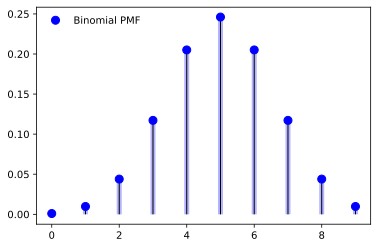

In [282]:



from scipy.stats import binom
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

n, p = 10, 0.5
mean, var, skew, kurt = binom.stats(n, p, moments='mvsk')

x = np.arange(binom.ppf(0.0001, n, p),
              binom.ppf(0.9999999, n, p))

ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='Binomial PMF')
ax.vlines(x, 0, binom.pmf(x, n, p), colors='b', lw=5, alpha=0.3)

rv = binom(n, p)
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1)
ax.legend(loc=2, frameon=False)
plt.show()